In [1]:
from tars import Tars, markets, portfolios, traders, strategies
from tars.utils import data
import pandas as pd
import numpy as np
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


# Backtester

Tars allows you to backtest your strategies. Below is an example where two Buy and Hold strategies are compared.

## The custom strategy

For the sake of the example they are actually the same and the only thing that changes is the initial amount that is invested.

In [2]:
from typing import NoReturn

from pandas import DataFrame, Timestamp

from tars.evaluators.trader_evaluator import TraderEvaluator
from tars.strategies.abstract_strategy import AbstractStrategy
import logging



class BuyAndHoldCustom(AbstractStrategy):
    """
    The buy and hold strategy is the reference strategy needed in all
    scenario of comparison as it allows for setting the baseline.

    :param trader: Trader
        The Trader handling a portfolio
    :param pair: str
        The pair e.g. XETHZUSD to buy and hold
    :param volume: float
        The volume of the pair's quote buy
    :param validate: boolean
        Safety Boolean to make sure not to trade real money by default

    :ivar has_run: boolean
        Boolean describing if the strategy has run or not yet.
    :ivar evaluator: AbstractEvaluator
        Evaluator allows for the evaluation of a strategy
    """

    def __init__(self, trader, pair, volume, validate=True):
        self.name = 'Buy and hold Custom'
        self.trader = trader
        self.pair = pair
        self.volume = volume
        self.validate = validate
        self.has_run = False
        self.evaluator = TraderEvaluator(self.trader)

    def run(self) -> NoReturn:
        """ Run the strategy """
        # Checkpoint
        balance = self.trader.portfolio.get_trade_balance().loc['eb']   
        self.evaluator.add_checkpoint(Timestamp.utcnow(), balance)
        # Run strategy
        if not self.has_run:
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
            self.has_run = True

    def test(self, dtime: Timestamp, data: DataFrame):
        """ Run the strategy """
        # Checkpoint
        balance = self.trader.portfolio.get_trade_balance(dtime).loc['eb'].ZUSD
        self.evaluator.add_checkpoint(dtime, balance)
        
        # Run strategy
        if not self.has_run:
            self.trader.add_order(dtime=dtime, pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
            self.has_run = True


## Usage

Load utility module and kraken key

In [3]:
from tars.utils import data
api_key = f'../kraken.key'

Create historical market

In [4]:
my_data = data.get_historical_ohlc_data(base='ETH', quote='USD', interval=720, data_folder='../../data/raw/')['2021':]
market = markets.HistoricalMarket()
market.load('XETHZUSD', my_data)

Create two portfolios, traders and strategies objects

In [13]:
portfolio_1 = portfolios.HistoricalPortfolio(market, {'ZUSD': 1000})
trader_1 = traders.HistoricalTrader(market, portfolio_1)
strategy_1 = BuyAndHoldCustom(trader_2, 'XETHZUSD', 0.2)

portfolio_2 = portfolios.HistoricalPortfolio(market, {'ZUSD': 1000})
trader_2 = traders.HistoricalTrader(market, portfolio_2)
strategy_2 = strategies.RandomInvestment(trader_2, 'XETHZUSD', 0.05)

portfolio_3 = portfolios.HistoricalPortfolio(market, {'ZUSD': 1000})
trader_3 = traders.HistoricalTrader(market, portfolio_3)
strategy_3 = strategies.SequentialInvestment(trader_3, 'XETHZUSD', 0.2, n_step=10)

Create Tars and load strategies

In [14]:
tars = Tars()
tars.load(strategy_1)
tars.load(strategy_2)
tars.load(strategy_3)

 🤖 TARS : Welcome to Endurance! 👨‍🚀
 🤖 TARS : Loaded strategy ➡️ Buy and hold Custom
 🤖 TARS : Loaded strategy ➡️ Random Investment
 🤖 TARS : Loaded strategy ➡️ Sequential Investment


### Run the backtest

Here, you can select the slice of the DataFrame that you want to run the backtest on. Logically, this slide of data has to be in the market otherwise it can't work.

In [15]:
tars.test(my_data.tail(100))

 🤖 TARS : Starting backtesting session 📈
 💪️ Loading :   
   🧵 'Thread-12' ➡️ 'Buy and hold Custom'
   🧵 'Thread-13' ➡️ 'Random Investment'
   🧵 'Thread-14' ➡️ 'Sequential Investment'
 The base XETH isn't available in the portfolio.
 The base XETH isn't available in the portfolio.
 The base XETH isn't available in the portfolio.


Check that the investments have been successfully bought.

In [16]:
portfolio_1.get_account_balance()

,vol
ZUSD,1000


In [17]:
portfolio_2.get_account_balance()

,vol
ZUSD,237.15
XETH,0.15


Now, Tars works as usual, you can evaluate the strategies that are (or have been) executed.

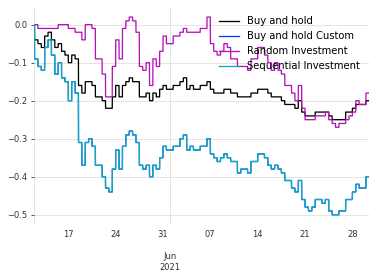

In [10]:
tars.evaluate(metric='cumulative return').plot();

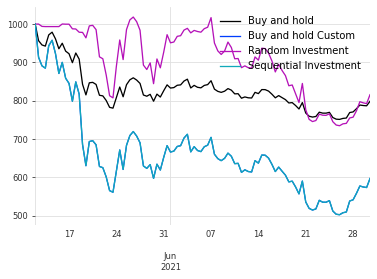

In [11]:
tars.plot()

In [12]:
trader_4.order_book

{'d321c90d': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee=0.2226276, volume=0.02),
 '3d0e7210': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee=0.2226276, volume=0.02),
 '02abcf84': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee=0.2226276, volume=0.02),
 '83174c15': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee=0.2226276, volume=0.02),
 '139da474': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee=0.2226276, volume=0.02),
 '18818a75': VirtualOrder(dtime=Timestamp('2021-05-12 00:00:00'), pair='XETHZUSD', ordertype='buy', type='market', price=4281.3, cost=85.626, fee

Since the historical runs are done completely offline, there is no need to stop the execution of Tars.

In [74]:
tars.is_running

False

---